In [1]:
import pyspark 
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round, when
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns
import random

In [2]:
# USEFUL CONSTANTS
MONTHS_SHORT = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
MONTHS_LONG = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
MONTHS_NUMBER = list(range(1, 13))
DAYS_SHORT = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
DAYS_LONG = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
DAYS_NUMBER = list(range(1, 32))
DAYS_NUMBER_WEEK = list(range(1, 8))
HOURS = list(range(24))

COLOR_RANGE = ['#aed6f1','#a9cce3','#d2b4de','#d7bde2','#f5b7b1','#e6b0aa','#fad7a0','#f9e79f','#abebc6',
               '#a9dfbf','#a2d9ce','#a3e4d7','#5dade2','#5499c7','#a569bd','#af7ac5','#ec7063','#cd6155',
               '#f5b041','#f4d03f','#58d68d','#52be80','#45b39d','#48c9b0','#2874a6','#1f618d','#6c3483',
               '#76448a','#b03a2e','#922b21','#af601a','#b9770e','#b7950b','#239b56','#1e8449','#117a65']

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlContext = SparkSession(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/12 16:23:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from IPython.display import display
from ipywidgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
import pyarrow as pa
from pyarrow import csv
sqlContext.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
%matplotlib inline

In [5]:
import matplotlib.patches as mpatches


# USEFUL PLOTTING FUNCTIONS
def linechart(title, x_names, y_data, x_label, y_label,
              width_fig=10, height_fig=8, font_size_xy="xx-large", 
              font_size_title=30, x_names_rotation="horizontal", color='blue'):
    '''
    title: the title of the graph
    x_names: names of the bars, on the x-axis
    y_data: heights of the bars
    x_label: label for the x-axis
    y_label: label for the y-axis
    width_fig: width of the figure
    height_fig: height of the figure
    font_size_xy: font size for the axis labels
    font_size_title: font size for the title of the graph
    x_names_rotation: rotation the x-names of the x-values
    color: the color of the bars
    '''
    x_data = list(range(len(x_names)))
    plt.figure(figsize=(width_fig, height_fig))
    plt.plot(x_data, y_data, color=color)
    plt.title(title, y=1.02, fontsize=font_size_title)
    plt.xlabel(x_label, y=1.3, fontsize=font_size_xy)
    plt.ylabel(y_label, x=1.3, fontsize=font_size_xy)
    plt.xticks(x_data, x_names, rotation=x_names_rotation)
    plt.xlim((0, x_data[-1]))
    plt.grid()
    plt.show()
    
    
def barchart_simple(title, x_names, y_data, x_label, y_label, 
                    width_fig=10, height_fig=8, font_size_xy="xx-large", font_size_title=30, color='teal', xnames_rotation='horizontal'):
    '''
    title: the title of the graph
    x_names: names of the bars, on the x-axis
    y_data: heights of the bars
    x_label: label for the x-axis
    y_label: label for the y-axis
    width_fig: width of the figure
    height_fig: height of the figure
    font_size_xy: font size for the axis labels
    font_size_title: font size for the title of the graph
    color: the color of the bars
    xnames_rotation: rotation for the names on the x-axis
    '''
    x_data = list(range(len(x_names)))
    plt.figure(figsize=(width_fig, height_fig))
    plt.bar(x_data, y_data, align="center", color=color)
    plt.title(title, y=1.02, fontsize=font_size_title)
    plt.xlabel(x_label, y=1.3, fontsize=font_size_xy)
    plt.ylabel(y_label, x=1.3, fontsize=font_size_xy)
    plt.xticks(x_data, x_names, rotation=xnames_rotation)
    plt.xlim((-0.5, x_data[-1]+0.5))
    plt.grid()
    plt.show()

def barchart_colored(title, x_names, y_data, color_data, x_label, y_label, legend_label, 
                     width_fig=10, height_fig=8, box_x=1.3, box_y=0.9, font_size_xy="xx-large", font_size_title=30, font_size_legend="x-large", thresholds=[0.084, 0.117, 0.152, 0.201]):
    '''
    title: the title of the graph
    x_data: x-position of the bar
    y_data: height of the bar
    color_data: color to associate to a bar, in order to represent an extra information
    x_label: label for the x axis
    y_label: label for the y axis
    legend_label: information we are representing with a color (ex: delay ratio)
    xticks: used to rename the x-values
    width_fig: width of the figure
    height_fig: height of the figure
    box_x: horizontal shift for the legend box
    box_y: vertical shift for the legend box
    font_size_xy: font size for the axis labels
    font_size_title: font size for the title of the graph
    font_size_legend: font size for the legend names
    thresholds: an array composed by four elements, used as threshold values for the colors
    '''
    # plot the initial graph (empty)
    fig = plt.figure(figsize=(width_fig, height_fig))                                             
    plt.title(title, y=1.02, fontsize=font_size_title)
    plt.xlabel(x_label, y=1.3, fontsize=font_size_xy)
    plt.ylabel(y_label, x=1.3, fontsize=font_size_xy)
    
    # now, we decide the colors for the bars
    def map_to_color(data, thresholds):
        if data <= thresholds[0]:
            color = 'lightgreen'
        elif data <= thresholds[1]:
            color = 'green'
        elif data <= thresholds[2]:
            color = 'gold'
        elif data <= thresholds[3]:
            color = 'orange'
        else:
            color = 'red'
        return color
    bar_colors = list(map(lambda x: map_to_color(x, thresholds), color_data))
        
    # draw the bars
    x_data = list(range(len(x_names)))
    plt.bar(x_data, y_data, align="center", color=bar_colors)
    plt.xticks(x_data, x_names)
    # draw the legend
    patch1 = mpatches.Patch(color='lightgreen', label=legend_label + ' < {}%'.format(__builtin__.round(thresholds[0]*100, 2)))
    patch2 = mpatches.Patch(color='green', label=legend_label + ' < {}%'.format(__builtin__.round(thresholds[1]*100, 2)))
    patch3 = mpatches.Patch(color='gold', label=legend_label + ' < {}%'.format(__builtin__.round(thresholds[2]*100, 2)))
    patch4 = mpatches.Patch(color='orange', label=legend_label + ' < {}%'.format(__builtin__.round(thresholds[3]*100, 2)))
    patch5 = mpatches.Patch(color='red', label=legend_label + ' >= {}%'.format(__builtin__.round(thresholds[3]*100, 2)))
    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(box_x, box_y), loc="upper right", fontsize=font_size_legend)
    # show the obtained chartbar
    plt.xlim((-0.5, x_data[-1]+0.5))
    plt.show()
    
def barchart_and_linechart(title, x_names, bar_data, line_data, x_label, bar_legend, line_legend,
                            width_fig=10, height_fig=8, box_x=1.3, box_y=0.9, font_size_xy="xx-large", 
                            font_size_title=30, font_size_legend="x-large", bar_color='teal', line_color='blue'):
    '''
    title: the title of the graph
    x_names: names of the bars, on the x-axis
    bar_data: heights of the bars
    line_data: y-values for the linechart
    x_label: label for the x-axis
    bar_legend: legend name for the barchart
    line_legend: legend name for the linechart
    width_fig: width of the figure
    height_fig: height of the figure
    box_x: horizontal shift for the legend box
    box_y: vertical shift for the legend box
    font_size_xy: font size for the axis labels
    font_size_title: font size for the title of the graph
    font_size_legend: font size for the legend names
    bar_color: the color of the barchart
    line_color: the color of the linechart
    '''
    x_data = list(range(len(x_names)))
    # we want to print normalized data
    max_bar = max(bar_data)
    max_line = max(line_data)
    bar_data = list(map(lambda x: x/max_bar, bar_data))
    line_data = list(map(lambda x: x/max_line, line_data))
    # plot the double graph
    plt.figure(figsize=(width_fig, height_fig))
    plt.bar(x_data, bar_data, align="center", color=bar_color)
    plt.plot(x_data, line_data, color=line_color)
    plt.title(title, y=1.02, fontsize=font_size_title)
    plt.xlabel(x_label, y=1.3, fontsize=font_size_xy)
    plt.ylabel("Normalized values", x=1.3, fontsize=font_size_xy)
    plt.xticks(x_data, x_names)
    plt.xlim((-0.5, x_data[-1]+0.5))
    plt.legend((line_legend, bar_legend), loc="upper right", bbox_to_anchor=(box_x, box_y), fontsize=font_size_legend)
    plt.grid()
    plt.show()
    
def barchart_cumulative(title, x_names, y_data, x_label, y_label, legend_names,
                          width_fig=10, height_fig=8, box_x=1.3, box_y=0.9, font_size_xy="xx-large", 
                          font_size_title=30, font_size_legend="x-large"):
    """
    title: title for the graph
    x_names: possible values for the x-axis (renamed by "xticks")
    y_data: list of bins' heights, for each bar
    x_label: label for the x axis
    y_label: label for the y axis
    legend_names: a list of names for the legend
    width_fig: width of the figure
    height_fig: height of the figure
    box_x: horizontal shift for the legend box
    box_y: vertical shift for the legend box
    font_size_xy: font size for the axis labels
    font_size_title: font size for the title of the graph
    font_size_legend: font size for the legend names
    """
    n_bins = len(legend_names)
    n_bars = len(x_names)
    
    # plot the initial graph (empty)
    plt.figure(figsize=(width_fig,height_fig))
    plt.title(title, y=1.02, fontsize=font_size_title)
    plt.xticks(list(range(n_bars)), x_names)
    plt.xlabel(x_label, y=1.3, fontsize=font_size_xy)
    plt.ylabel(y_label, x=1.3, fontsize=font_size_xy)

    # define colors for the bins with a control on the color range
    if n_bins > len(COLOR_RANGE):
        raise IndexError
    else:
        bin_colors = COLOR_RANGE[0:n_bins]
        
    # cumulative bars needs to specify the current height's level in order to be plotted properly
    previous_heights = [0]*n_bars

    # print the bins
    for i, current_bin_id in enumerate(range(len(legend_names))):
        # data for the current bin in analysis
        data = [0]*n_bars
        for bar_index, bar_bin in enumerate(y_data):
            data[bar_index] = bar_bin[current_bin_id]
        # draw the current set of bins
        plt.bar(list(range(n_bars)), data, bottom=previous_heights, color=bin_colors[i], align="center")
        # update the bases
        for i in range(n_bars):
            previous_heights[i] += data[i]

    # show the obtained graph
    plt.legend(legend_names, loc="upper right", bbox_to_anchor=(box_x, box_y), fontsize=font_size_legend)
    plt.grid()
    plt.show()
    
def grid_chart(title, matrix_data, x_names, y_names, x_label, y_label,
              width_fig=10, height_fig=8, font_size_xy="xx-large", font_size_title=30, vmin=None):
    '''
    title: title for the graph
    matrix_data: data to show on the graph. Content is remapped using a color
    x_names: names for the columns
    y_names: names for the rows
    x_label: label for the x axis
    y_label: label for the y axis
    width_fig: width of the figure
    height_fig: height of the figure
    font_size_xy: font size for the axis labels
    font_size_title: font size for the title of the graph
    vmin: the minimum visible value, whose color associated is the bottom one in the legend (evaluated automatically if not specified) 
    '''
    # draw the initial figure (empty)
    plt.figure(figsize=(width_fig,height_fig))
    plt.title(title, y=1.02, fontsize=font_size_title)
    # draw a heatmap
    cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
    cmap.set_under(".5")  #hide values lower than vmin
    sns.heatmap(matrix_data, xticklabels=x_names, yticklabels=y_names, vmin=vmin, cmap=cmap)
    # show the resulting graph
    plt.xlabel(x_label, y=1.3, fontsize=font_size_xy)
    plt.ylabel(y_label, x=1.3, fontsize=font_size_xy)
    plt.show()

In [6]:
# USEFUL FUNCTIONS TO MANIPULATE DATA
def query_column(query_result, index, offset = None):
    '''
    Retrieve a column from a dataframe, collected as a list of "Rows"
    
    query_result: the dataframe (list), from which retrieve a column as a list
    index: the index of the column to retrieve
    offset: optional offset value to add/concatenate to values of the selected column
    '''
    if offset is None:
        res = list(map(lambda x: x[index], query_result))
    else:
        res = list(map(lambda x: x[index] + offset, query_result))
    return res

def query_grouping(query_result, grouping_column_index, order_column_index, values_column_index):
    '''
    Retrieve a matrix from a dataframe, collected as a list of "Rows".
    => The idea: values (in column "values_column_index") are grouped into classes (rows of the matrix, according to values in the column "grouping_column_index").
       Then, data are sorted inside each group (according to values in the column "order_column_index").
    GROUPS = ROWS
    ORDER = COLUMNS
    
    query_result: the dataframe (list), from which retrieve elements as a matrix
    grouping_column_index: this is the index of the column of the dataframe to be used as row identifier in the matrix
    order_column_index: this is the index of the column of the dataframe to be used as column identifier in the matrix
    values_column_index: this is the index of the column of the dataframe used to specify the data (content of the matrix) 
    '''
    # retrieve the columns of the dataframe
    row_ids = query_column(query_result, grouping_column_index)
    col_ids = query_column(query_result, order_column_index)
    values = query_column(query_result, values_column_index)
    # they have the same size
    n = len(row_ids)
    # retrieve dimensions for the resulting matrix: the least value has to be mapped as a '0'
    max_row = max(row_ids)
    min_row = min(row_ids)
    max_col = max(col_ids)
    min_col = min(col_ids)
    n_rows = max_row - min_row + 1
    n_cols = max_col - min_col + 1
    # initialize the resulting matrix
    res = [0]*n_rows
    for i in range(len(res)):
        res[i] = [0]*n_cols
    # place values into the matrix
    for i in range(n):
        r = row_ids[i] - min_row  # this allow to map the row in the range [0, n_rows-1]
        c = col_ids[i] - min_col  # this allow to map the col in the range [0, n_cols-1]
        v = values[i]
        res[r][c] = v
    # the matrix is now created
    return res

# PRINTING FUNCTIONS
def print_results(query_result, key_names, description, key_index=0, value_index=1):
    """
    Print the result collected from the DataFrame.
    
    query_result: (list) the result of a dataframe, collected as a list
    key_names: (list) of names for each element of the row (eg. months, days...)
    description: (str) for describing the value
    key_index: the column index of "query_result" in which we can find the keys
    value_index: the column index of "query_result" in which we can find the values
    """
    # retrieve the keys and the values
    keys = query_column(query_result, key_index)
    values = query_column(query_result, value_index)
    L = len(keys)
    # we want to remap keys in the range [0, len(key_names)-1], 
    # in order to have a correspondance with indexes of "key_names"
    min_key = min(keys)
    keys = list(map(lambda x: x - min_key, keys))
    # print them
    for i in range(L):
        print("{}: {} {:>10}".format(key_names[keys[i]], values[i], description))

def print_ratio_perc(total_values, fraction_values, percentage_resulting_vector=None, description=""):
    """
    Print the ratio between the passed list of total values and the fractionary values. 
    The function accepts also a vector for sotring the result. The passing vector is a 
    2D vector, where the second row of the matrix is filled (eg. sample[1] = []).
    
    total_values: the (list) of the total values
    fraction_values: the (list) of the fractionary vlues
    percentage_resulting_vector: it's a (list<list, list>) where the second index is filled with the results
    """

    for num, val in enumerate(zip(total_values, fraction_values)):

        perc =  __builtin__.round(val[1][1] / val[0][1]*100, 2)
        # need to append in order to print the graph later
        if percentage_resulting_vector is not None:
            percentage_resulting_vector[1].append(perc)
        print("- {desc} {}: {:>9}%".format(num+1, perc, desc=description))

In [7]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *


df = sqlContext.read.load('2001.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

In [8]:
for elem in df.dtypes:
    print(elem)
print("\n\n")
df.printSchema()

('Year', 'int')
('Month', 'int')
('DayofMonth', 'int')
('DayOfWeek', 'int')
('DepTime', 'int')
('CRSDepTime', 'int')
('ArrTime', 'int')
('CRSArrTime', 'int')
('UniqueCarrier', 'string')
('FlightNum', 'int')
('TailNum', 'string')
('ActualElapsedTime', 'int')
('CRSElapsedTime', 'int')
('AirTime', 'int')
('ArrDelay', 'int')
('DepDelay', 'int')
('Origin', 'string')
('Dest', 'string')
('Distance', 'int')
('TaxiIn', 'int')
('TaxiOut', 'int')
('Cancelled', 'int')
('CancellationCode', 'string')
('Diverted', 'int')
('CarrierDelay', 'string')
('WeatherDelay', 'string')
('NASDelay', 'string')
('SecurityDelay', 'string')
('LateAircraftDelay', 'string')



root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrie

In [9]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nu

22/05/12 16:27:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+-------------+------------------+-------+------------------+------------------+------------------+------------------+------------------+-------+-------+-----------------+-----------------+------------------+-------------------+----------------+--------------------+------------+------------+--------+-------------+-----------------+
|summary|   Year|             Month|        DayofMonth|         DayOfWeek|           DepTime|scheduled_departure_time|           ArrTime|        CRSArrTime|UniqueCarrier|         FlightNum|TailNum| ActualElapsedTime|    CRSElapsedTime|           AirTime|          ArrDelay|          DepDelay| Origin|   Dest|         Distance|           TaxiIn|           TaxiOut|          Cancelled|CancellationCode|            Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+-------+-------+-----

In [10]:
# create the input RDD
data = sc.textFile('2001.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
        # replace the 'missing data' (NA) by empty value
        # 1- split lines (separator = ',')
        # 2- replace NA with ''
        # 3- recreate the line (reintroducing ',')
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

# define the schema
airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

# the input RDD<String> is ready: later, we will introduce the schema

In [11]:
# convert each line into a tuple of features (columns) with the corresponding data type
# in case of empty string, the value is set to None
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         )
        )             
)
    
# create dataframe
# note: we are working only on a subset of the table columns
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])

In [12]:
df[df.scheduled_departure_time > 1800].count()

1273129

In [13]:
myRow = df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()
for row in myRow:
    print("Carrier: {} -- count: {}".format(row[0], row[1]))

Carrier: WN -- count: 211670
Carrier: DL -- count: 198346
Carrier: US -- count: 154417
Carrier: UA -- count: 139047
Carrier: AA -- count: 138232
Carrier: NW -- count: 112500
Carrier: MQ -- count: 95089
Carrier: CO -- count: 70936
Carrier: TW -- count: 54426
Carrier: HP -- count: 53747
Carrier: AS -- count: 37307
Carrier: AQ -- count: 7412


In [14]:
df.createOrReplaceTempView("flights")
res = sqlContext.sql("SELECT COUNT(DISTINCT src_airport) AS number_origin_airports FROM flights")
res.show()

res_a = df.select("src_airport").distinct().count()
print("Number of distinct source airports: {}".format(str(res_a)))

+----------------------+
|number_origin_airports|
+----------------------+
|                   231|
+----------------------+



Number of distinct source airports: 231


In [15]:
res = sqlContext.sql("SELECT COUNT(DISTINCT dest_airport) AS number_destination_airports FROM flights")
res.show()

number_of_airports = df.select("dest_airport").distinct().count()
print("Number of distinct destination airports: {}".format(str(number_of_airports)))

+---------------------------+
|number_destination_airports|
+---------------------------+
|                        230|
+---------------------------+



Number of distinct destination airports: 230


In [16]:
res = sqlContext.sql("SELECT COUNT(DISTINCT carrier) AS res FROM flights")
res.show()

number_of_carriers = df.select("carrier").distinct().count()
print("Number of distinct carriers: {}".format(str(number_of_carriers)))

+---+
|res|
+---+
| 12|
+---+



Number of distinct carriers: 12


In [17]:
res = sqlContext.sql("SELECT COUNT(*) AS night_flghts FROM flights WHERE scheduled_departure_time > 1800 OR scheduled_departure_time < 600")
res.show()

night_flights = df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)].count()
print("Number of night flights: {}".format(str(night_flights)))

+------------+
|night_flghts|
+------------+
|     1323829|
+------------+



Number of night flights: 1323829


In [18]:
res = sqlContext.sql("SELECT COUNT(*) AS total_flights FROM flights")
res.show()

total_flights = df.count()
print("Number of total flights: {}".format(str(total_flights)))

+-------------+
|total_flights|
+-------------+
|      5967780|
+-------------+



Number of total flights: 5967780


In [19]:
# round method has been overwritten with the imports: use __builtin__.round() instead
print("The percentage of night flights over the volume of flights is: {} %".format(str(__builtin__.round(night_flights/total_flights*100, 2))))

The percentage of night flights over the volume of flights is: 22.18 %


In [20]:
res = sqlContext.sql("SELECT month, COUNT(*) AS number_of_flights FROM flights GROUP BY month ORDER BY month")
res.show()

month_flights = df.groupBy(df.month).count().orderBy(df.month).collect()

#print_results(month_flights, MONTHS_LONG, "flights")

+-----+-----------------+
|month|number_of_flights|
+-----+-----------------+
|    1|           529940|
|    2|           477824|
|    3|           531119|
|    4|           514187|
|    5|           529940|
|    6|           520230|
|    7|           538440|
|    8|           544351|
|    9|           490698|
|   10|           443796|
|   11|           417386|
|   12|           429869|
+-----+-----------------+



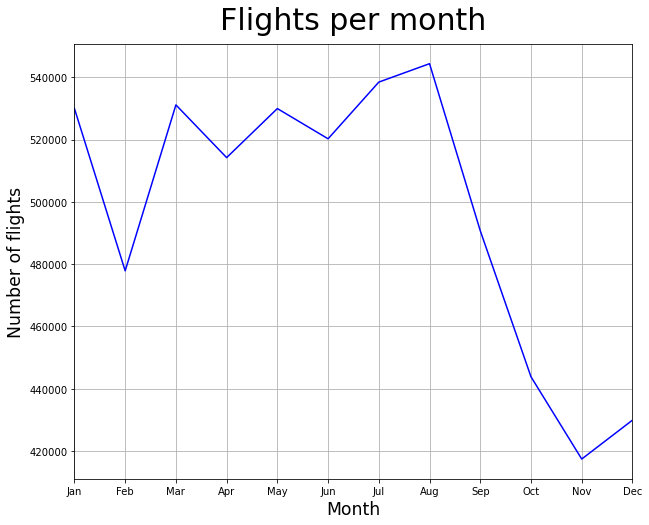

In [21]:
y_data = query_column(month_flights, 1)
linechart("Flights per month", MONTHS_SHORT, y_data, "Month", "Number of flights")

In [22]:
res = sqlContext.sql("SELECT day_of_week, COUNT(*) AS res FROM flights GROUP BY day_of_week ORDER BY day_of_week")
res.show()

daily_week_flights = df.groupBy(df.day_of_week).count().orderBy(df.day_of_week).collect()
#print_results(daily_week_flights, DAYS_LONG, "flights")

+-----------+------+
|day_of_week|   res|
+-----------+------+
|          1|881379|
|          2|871342|
|          3|871772|
|          4|870683|
|          5|871140|
|          6|772781|
|          7|828683|
+-----------+------+



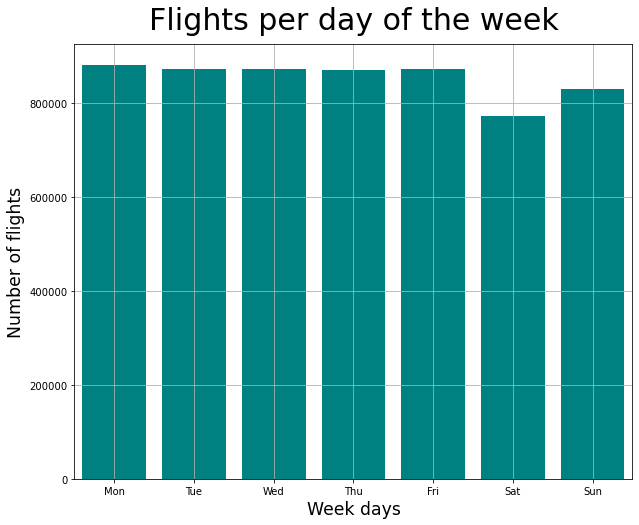

In [23]:
y_data = query_column(daily_week_flights, 1)

barchart_simple("Flights per day of the week", DAYS_SHORT, y_data, "Week days", "Number of flights")

In [24]:
res = sqlContext.sql("SELECT month, day_of_week, COUNT(*) AS res FROM flights GROUP BY month, day_of_week ORDER BY month, day_of_week")
res.show(10)

daily_week_flights_per_month = df.groupBy(df.month, df.day_of_week).count().orderBy(df.month, df.day_of_week).collect()

#print("Number of flights per day of the week on a monthly basis: {}".format(str(daily_week_flights_per_month)))

+-----+-----------+-----+
|month|day_of_week|  res|
+-----+-----------+-----+
|    1|          1|86149|
|    1|          2|87584|
|    1|          3|87548|
|    1|          4|70108|
|    1|          5|70210|
|    1|          6|61321|
|    1|          7|67020|
|    2|          1|69831|
|    2|          2|69969|
|    2|          3|70000|
+-----+-----------+-----+
only showing top 10 rows



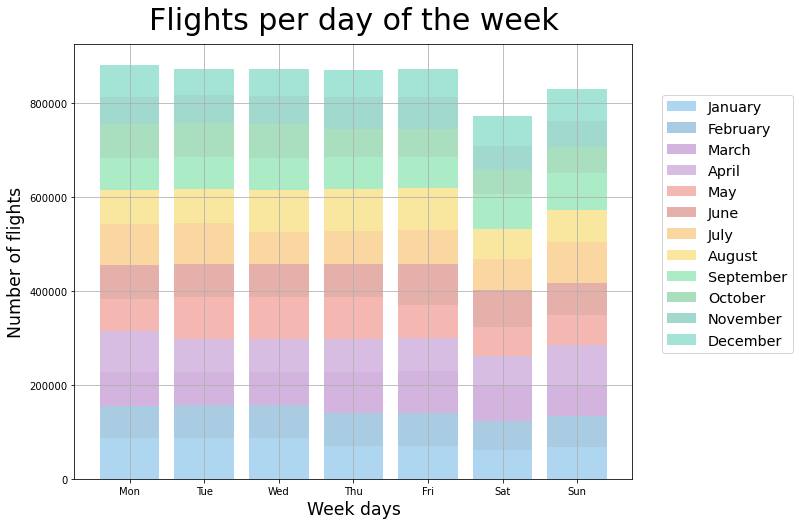

In [25]:
y_data = query_grouping(daily_week_flights_per_month, 1, 0, 2)

barchart_cumulative("Flights per day of the week", DAYS_SHORT, y_data, "Week days", "Number of flights", MONTHS_LONG)

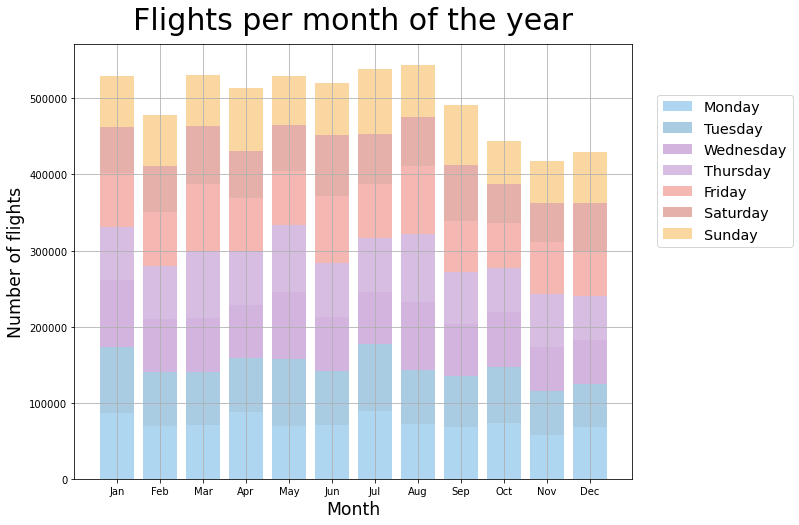

In [26]:
y_data = query_grouping(daily_week_flights_per_month, 0, 1, 2)

barchart_cumulative("Flights per month of the year", MONTHS_SHORT, y_data, "Month", "Number of flights", DAYS_LONG)

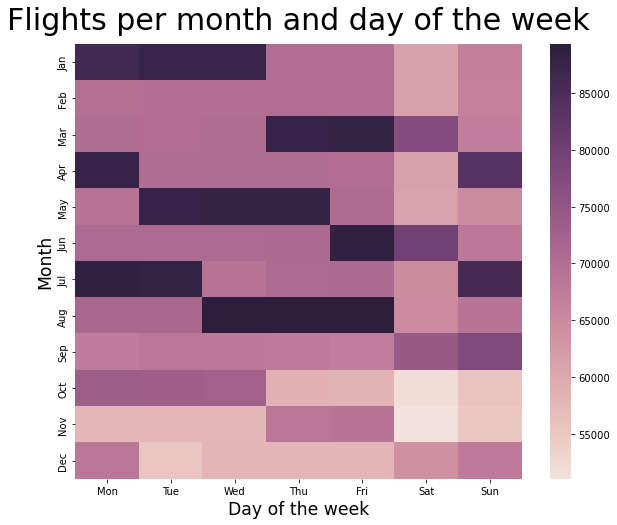

In [27]:
grid_chart("Flights per month and day of the week", y_data, DAYS_SHORT, MONTHS_SHORT, "Day of the week", "Month")

In [28]:
# FLIGHTS PER DAY OF MONTH -- GLOBAL SCALE 

res = sqlContext.sql("SELECT day_of_month, COUNT(*) AS number_of_flights FROM flights GROUP BY day_of_month ORDER BY day_of_month")
res.show(10)

flight_day_month = df.groupBy(df.day_of_month).count().orderBy(df.day_of_month).collect()
#print("Number of flights per day of the month -- global: {}".format(str(flight_day_month)))

+------------+-----------------+
|day_of_month|number_of_flights|
+------------+-----------------+
|           1|           194297|
|           2|           195917|
|           3|           193906|
|           4|           196247|
|           5|           199052|
|           6|           197475|
|           7|           197274|
|           8|           197196|
|           9|           198950|
|          10|           195595|
+------------+-----------------+
only showing top 10 rows



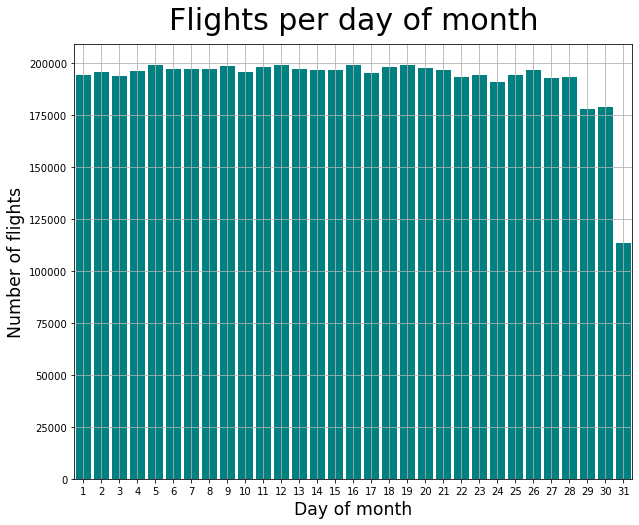

In [29]:
y_data = query_column(flight_day_month, 1)

barchart_simple("Flights per day of month", DAYS_NUMBER, y_data, "Day of month", "Number of flights")

In [30]:
# FLIGHTS PER HOUR OF DAY -- GLOBAL SCALE
res = sqlContext.sql("SELECT INT(scheduled_departure_time/100)%24 AS hour, COUNT(*) AS number_of_flights FROM flights GROUP BY INT(scheduled_departure_time/100)%24 ORDER BY INT(scheduled_departure_time/100)%24")
res.show(10)

flight_hour_day = df.groupBy(round(df.scheduled_departure_time/100-0.5)%24).count().orderBy(round(df.scheduled_departure_time/100-0.5)%24).collect()
#print("Number of flights per hour of the day -- global: {}".format(str(flight_hour_day)))

+----+-----------------+
|hour|number_of_flights|
+----+-----------------+
|   0|            10441|
|   1|             8611|
|   2|              690|
|   3|              156|
|   5|            30803|
|   6|           394893|
|   7|           423576|
|   8|           412446|
|   9|           394080|
|  10|           333028|
+----+-----------------+
only showing top 10 rows



In [32]:
# FLIGHTS PER MONTH AND DAY OF MONTH -- MONTHLY SCALE 
res = sqlContext.sql("SELECT month, day_of_month, COUNT(*) AS number_of_flights FROM flights GROUP BY month, day_of_month ORDER BY month, day_of_month")
res.show(10)

flight_month_day_month = df.groupBy(df.month, df.day_of_month).count().orderBy(df.month, df.day_of_month).collect()
#print("Number of flights per month and day of the month -- monthly: {}".format(str(flight_month_day_month)))

+-----+------------+-----------------+
|month|day_of_month|number_of_flights|
+-----+------------+-----------------+
|    1|           1|            16081|
|    1|           2|            17612|
|    1|           3|            17573|
|    1|           4|            17570|
|    1|           5|            17576|
|    1|           6|            15422|
|    1|           7|            16831|
|    1|           8|            17491|
|    1|           9|            17485|
|    1|          10|            17483|
+-----+------------+-----------------+
only showing top 10 rows



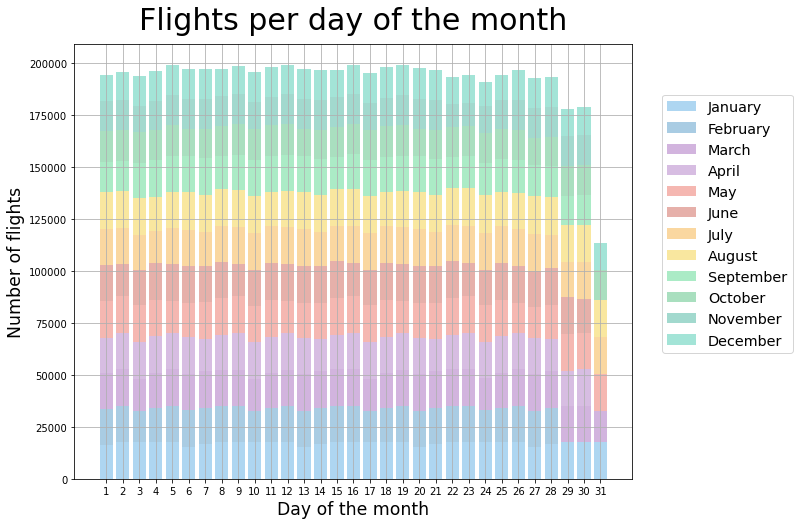

In [33]:
y_data = query_grouping(flight_month_day_month, 1, 0, 2)

barchart_cumulative("Flights per day of the month", DAYS_NUMBER, y_data, "Day of the month", "Number of flights", MONTHS_LONG)

In [42]:
# TOP 20 INBOUND
res = sqlContext.sql("SELECT dest_airport, COUNT(*) AS res FROM flights GROUP BY dest_airport ORDER BY res DESC LIMIT 20")
res.show()

top_20_inbound = df\
                    .groupBy(df.dest_airport)\
                    .count()\
                    .orderBy("count", ascending=0)\
                    .take(20)

+------------+------+
|dest_airport|   res|
+------------+------+
|         ORD|341352|
|         DFW|312325|
|         ATL|251492|
|         LAX|225035|
|         PHX|184308|
|         STL|162290|
|         DTW|148755|
|         MSP|142448|
|         LAS|136186|
|         BOS|133019|
|         DEN|132593|
|         IAH|128612|
|         CLT|128277|
|         SFO|121738|
|         EWR|120494|
|         PHL|119704|
|         LGA|116494|
|         PIT|106377|
|         SEA|102734|
|         BWI| 99840|
+------------+------+



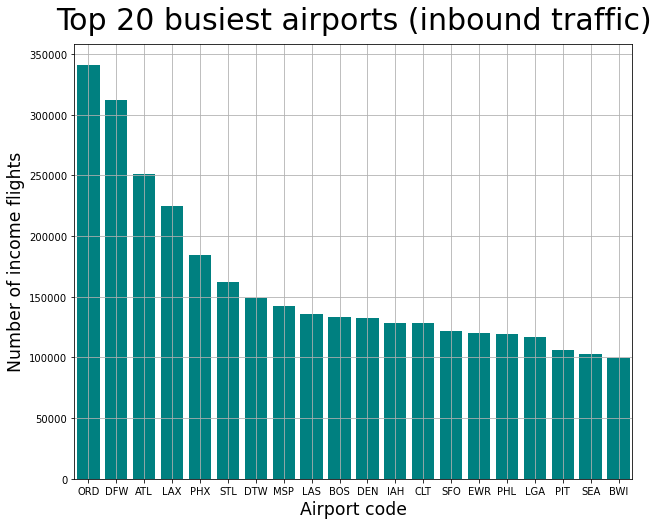

In [43]:
x_names = query_column(top_20_inbound, 0)
y_data = query_column(top_20_inbound, 1)

barchart_simple("Top 20 busiest airports (inbound traffic)", x_names, y_data, "Airport code", "Number of income flights")

In [44]:
# TOP 20 OUTBOUND flights
res = sqlContext.sql("SELECT src_airport, COUNT(*) AS res FROM flights GROUP BY src_airport ORDER BY res DESC LIMIT 20")
res.show()

top_20_outbound = df\
                    .groupBy(df.src_airport)\
                    .count()\
                    .orderBy("count", ascending=0)\
                    .take(20)

+-----------+------+
|src_airport|   res|
+-----------+------+
|        ORD|341284|
|        DFW|312036|
|        ATL|251671|
|        LAX|224984|
|        PHX|184323|
|        STL|162187|
|        DTW|148767|
|        MSP|142507|
|        LAS|136107|
|        BOS|133013|
|        DEN|132591|
|        IAH|128581|
|        CLT|128349|
|        SFO|121735|
|        EWR|120522|
|        PHL|119686|
|        LGA|116470|
|        PIT|106361|
|        SEA|102752|
|        BWI| 99834|
+-----------+------+



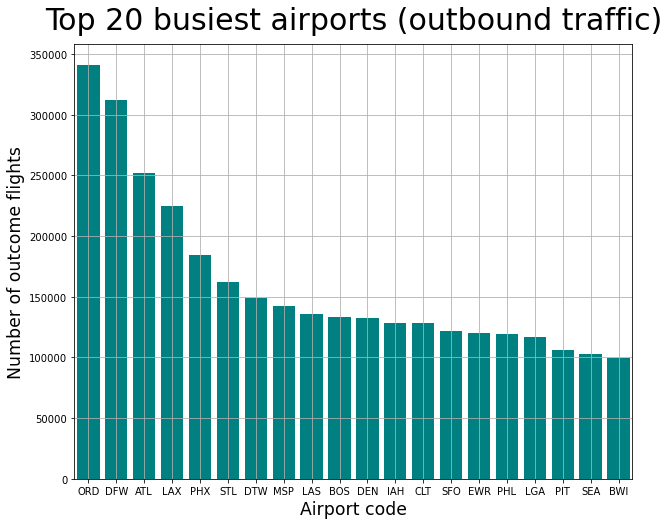

In [45]:
x_names = query_column(top_20_outbound, 0)
y_data = query_column(top_20_outbound, 1)

barchart_simple("Top 20 busiest airports (outbound traffic)", x_names, y_data, "Airport code", "Number of outcome flights")

In [46]:
# TOP 20 total flight
query1 = "SELECT src_airport, COUNT(*) AS res1 FROM flights GROUP BY src_airport"
query2 = "SELECT dest_airport, COUNT(*) AS res2 FROM flights GROUP BY dest_airport"
res = sqlContext.sql("SELECT src_airport AS airport_id, res1+res2 AS res FROM ({}) AS src, ({}) AS dst WHERE src_airport=dest_airport ORDER BY res DESC LIMIT 20".format(query1, query2))
res.show()

total_inbound = df\
                    .groupBy(df.dest_airport)\
                    .count().withColumnRenamed("count", "count_in")
total_outbound = df\
                    .groupBy(df.src_airport)\
                    .count()\
                    .withColumnRenamed("count", "count_out")

total_joined = total_inbound\
                        .join(total_outbound, total_inbound.dest_airport == total_outbound.src_airport)

top20_total_in_out = total_joined\
                        .select(total_joined.src_airport.alias('airport_id'), (total_joined.count_in+total_joined.count_out).alias('count_in_out'))\
                        .orderBy('count_in_out', ascending=0).limit(20)

+----------+------+
|airport_id|   res|
+----------+------+
|       ORD|682636|
|       DFW|624361|
|       ATL|503163|
|       LAX|450019|
|       PHX|368631|
|       STL|324477|
|       DTW|297522|
|       MSP|284955|
|       LAS|272293|
|       BOS|266032|
|       DEN|265184|
|       IAH|257193|
|       CLT|256626|
|       SFO|243473|
|       EWR|241016|
|       PHL|239390|
|       LGA|232964|
|       PIT|212738|
|       SEA|205486|
|       BWI|199674|
+----------+------+



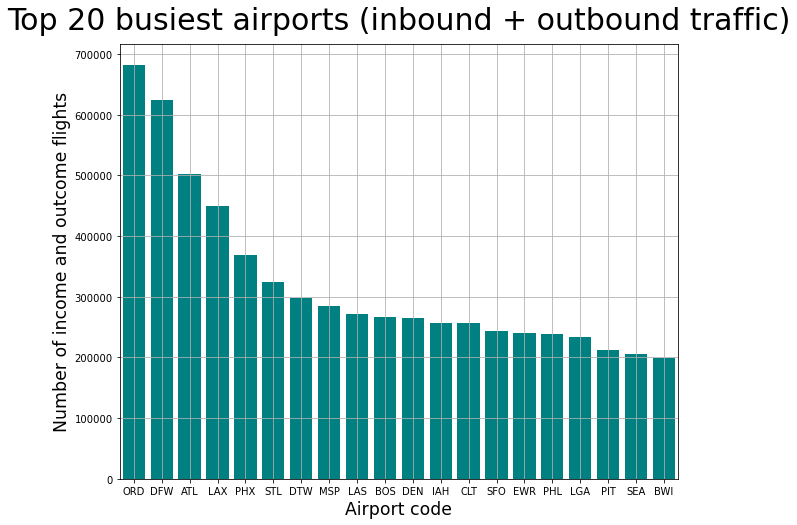

In [47]:
data = top20_total_in_out.take(20)
x_names = query_column(data, 0)
y_data = query_column(data, 1)

barchart_simple("Top 20 busiest airports (inbound + outbound traffic)", x_names, y_data, "Airport code", "Number of income and outcome flights")

In [34]:
# TOP 20 BUSIEST CARRIERS 
res = sqlContext.sql("SELECT carrier, COUNT(*) AS number_of_flights FROM flights GROUP BY carrier ORDER BY number_of_flights DESC LIMIT 20")
res.show()

top20_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0).withColumnRenamed('count', 'number_of_flights').limit(20)

+-------+-----------------+
|carrier|number_of_flights|
+-------+-----------------+
|     WN|           957145|
|     DL|           835236|
|     AA|           716985|
|     UA|           704977|
|     US|           688748|
|     NW|           533045|
|     MQ|           489418|
|     CO|           377281|
|     TW|           244721|
|     HP|           209979|
|     AS|           156447|
|     AQ|            53798|
+-------+-----------------+



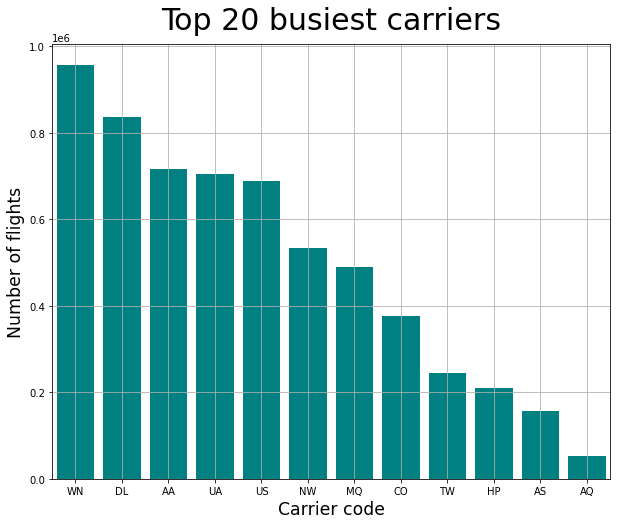

In [35]:
data = top20_carriers.collect()
x_names = query_column(data, 0)
y_data = query_column(data, 1)

barchart_simple("Top 20 busiest carriers", x_names, y_data, "Carrier code", "Number of flights")

In [37]:
# DELAYED FLIGHTS PER HOURS 
res = sqlContext.sql("SELECT INT(scheduled_departure_time/100)%24 AS hour, COUNT(*) AS number_of_flights FROM flights WHERE arrival_delay > 15 GROUP BY INT(scheduled_departure_time/100)%24 ORDER BY INT(scheduled_departure_time/100)%24")
res.show(10)

delayed_per_hour = df.filter(df.arrival_delay > 15)\
                        .groupBy(round(df.scheduled_departure_time/100 - 0.5)%24)\
                        .count().orderBy(round(df.scheduled_departure_time/100 - 0.5)%24).collect()

+----+-----------------+
|hour|number_of_flights|
+----+-----------------+
|   0|             1388|
|   1|             1275|
|   2|               83|
|   3|               11|
|   5|             2185|
|   6|            33947|
|   7|            47172|
|   8|            55266|
|   9|            56400|
|  10|            48892|
+----+-----------------+
only showing top 10 rows



In [40]:
# DELAYED FLIGHTS PER AIRPORT, IN 2001
delayed_in_flights_per_airport = "SELECT src_airport, COUNT(*) AS number_of_in_flights FROM flights WHERE arrival_delay > 15 GROUP BY src_airport"
delayed_out_flights_per_airport = "SELECT dest_airport, COUNT(*) AS number_of_out_flights FROM flights WHERE arrival_delay > 15 GROUP BY dest_airport"
delayed_flights_per_airport = sqlContext.sql("SELECT src_airport AS airport_id, number_of_in_flights + number_of_out_flights AS delayed_flights FROM ({}), ({}) WHERE src_airport = dest_airport ORDER BY src_airport".format(delayed_in_flights_per_airport, delayed_out_flights_per_airport))

delayed_flights_per_airport.show()

+----------+---------------+
|airport_id|delayed_flights|
+----------+---------------+
|       ABE|           1515|
|       ABI|            693|
|       ABQ|          11153|
|       ACT|            627|
|       ADQ|            284|
|       AKN|            122|
|       ALB|           5896|
|       AMA|           1863|
|       ANC|           9315|
|       APF|            137|
|       ATL|          92397|
|       AUS|          12019|
|       AVL|            368|
|       AVP|            402|
|       AZO|            986|
|       BDL|          12204|
|       BET|            383|
|       BFL|            631|
|       BGM|            112|
|       BGR|           2055|
+----------+---------------+
only showing top 20 rows



In [54]:
# DELAYED FLIGHTS PER TOP 20 BUSIEST AIRPORT, IN 2001
# Dataframe "top20_total_in_out" contains the top 20 busiest airports
# Airport_Id, number_of_flights
top20_list = list(map(lambda x: x['airport_id'], top20_total_in_out.select('airport_id').take(20)))

# retrieve information, maintaining airport IATA codes ordered according to the top-20 ranking
top20_airports_with_delay = delayed_flights_per_airport\
                                            .filter(col('airport_id').isin(top20_list))\
                                            .join(top20_total_in_out, 'airport_id')\
                                            .orderBy('count_in_out', ascending=False)
                                            
delayed_flights_per_busiest_airport = top20_airports_with_delay.select('airport_id', 'delayed_flights')
delayed_flights_per_busiest_airport.show()

+----------+---------------+
|airport_id|delayed_flights|
+----------+---------------+
|       ORD|         145152|
|       DFW|         106527|
|       ATL|          92397|
|       LAX|          88772|
|       PHX|          69269|
|       STL|          52476|
|       DTW|          49288|
|       MSP|          48631|
|       LAS|          50985|
|       BOS|          52807|
|       DEN|          51856|
|       IAH|          40492|
|       CLT|          38668|
|       SFO|          50459|
|       EWR|          45640|
|       PHL|          51939|
|       LGA|          43596|
|       PIT|          33083|
|       SEA|          49465|
|       BWI|          34756|
+----------+---------------+



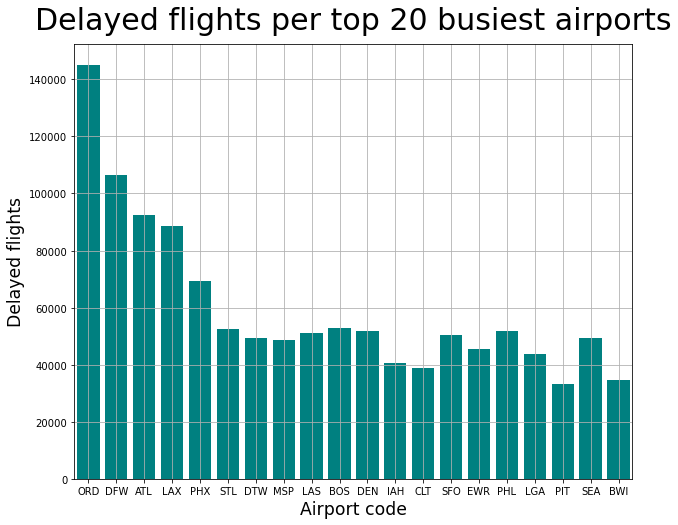

In [55]:
res = delayed_flights_per_busiest_airport.collect()
x_names = query_column(res, 0)
y_data = query_column(res, 1)

barchart_simple("Delayed flights per top 20 busiest airports", x_names, y_data, "Airport code", "Delayed flights")

In [56]:
# DELAY PROBABILITY FOR THE TOP 20 BUSIEST AIRPORTS, IN 2001
delay_probability_per_busiest_airports = top20_airports_with_delay\
                                            .select('airport_id', (top20_airports_with_delay.delayed_flights / top20_airports_with_delay.count_in_out).alias('delay_prob'))

delay_probability_per_busiest_airports.show()

+----------+-------------------+
|airport_id|         delay_prob|
+----------+-------------------+
|       ORD|0.21263455194276307|
|       DFW|0.17061763947459882|
|       ATL| 0.1836323418057369|
|       LAX|0.19726278223808327|
|       PHX|0.18790877598465675|
|       STL|0.16172486801838035|
|       DTW|0.16566169896679908|
|       MSP|0.17066203435630187|
|       LAS|0.18724315351478005|
|       BOS|0.19849867685090516|
|       DEN|0.19554724266924098|
|       IAH|0.15743818844214266|
|       CLT|0.15067841917810354|
|       SFO|0.20724679943977362|
|       EWR|  0.189365021409367|
|       PHL| 0.2169639500396842|
|       LGA|0.18713620988650606|
|       PIT|0.15551053408417867|
|       SEA|0.24072199565907165|
|       BWI|0.17406372386990795|
+----------+-------------------+



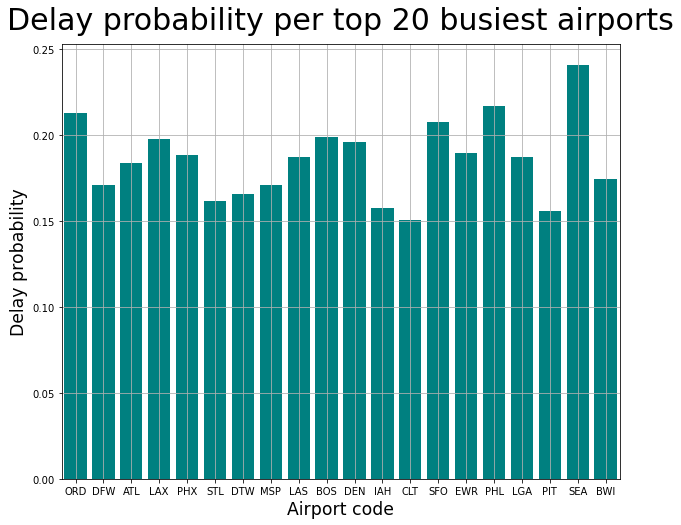

In [57]:
res = delay_probability_per_busiest_airports.collect()
x_names = query_column(res, 0)
y_data = query_column(res, 1)

barchart_simple("Delay probability per top 20 busiest airports", x_names, y_data, "Airport code", "Delay probability")

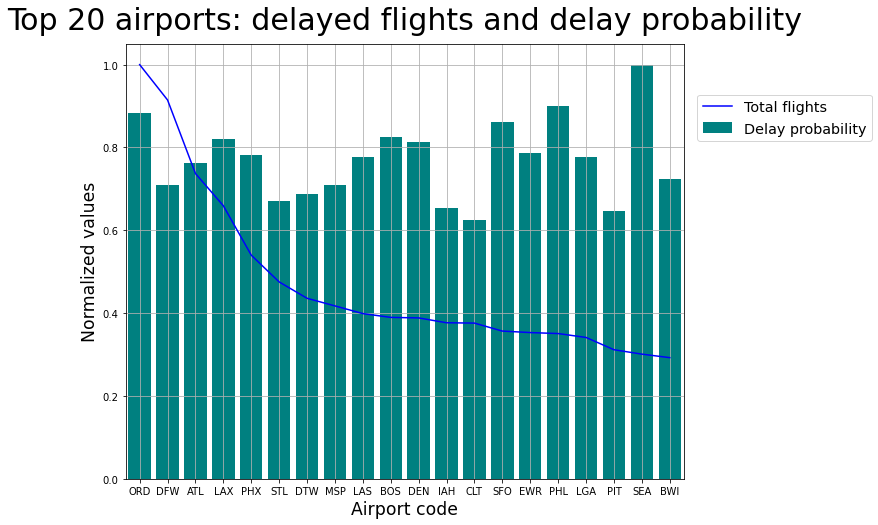

In [58]:
line_data = query_column(top20_total_in_out.take(20), 1)

barchart_and_linechart("Top 20 airports: delayed flights and delay probability", x_names, y_data, line_data, "Airport code", "Delay probability", "Total flights", box_x=1.35)

In [59]:
# DELAYED FLIGHTS PER CARRIER, IN 2001
delayed_flights_per_carrier = sqlContext.sql("SELECT carrier, COUNT(*) AS delayed_flights FROM flights WHERE arrival_delay > 15 GROUP BY carrier ORDER BY carrier")
delayed_flights_per_carrier.show()

+-------+---------------+
|carrier|delayed_flights|
+-------+---------------+
|     AA|         133076|
|     AQ|           6490|
|     AS|          39926|
|     CO|          58412|
|     DL|         141469|
|     HP|          44035|
|     MQ|         101776|
|     NW|          85359|
|     TW|          39029|
|     UA|         144704|
|     US|         112605|
|     WN|         146938|
+-------+---------------+

